In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display
import librosa.segment


from scipy import signal

## Control Parameters:

In [2]:
sr = 48000 #sample rate

## Helper functions:

In [3]:
'''
Description:
    Plots the boundaries along with signal waveform. 
Parameters:
    waveform (numpy.ndarray): array of signal amplitudes
    boundaries (numpy.ndarray): array of waveform indices where boundaries exist
    sr (int): sample rate of waveform
Return:
    None

'''
def plot_boundaries_on_signal(signal, boundaries, sr):
    hi, lo = max(signal), min(signal) 
    no_samples = len(signal)
    plt.vlines(boundaries/sr, lo, hi, colors='Red', linestyles='dotted')
    plt.plot(np.linspace(0, no_samples/sr, no_samples), signal)

In [4]:
'''
Description:
    Splices a signal to [t1, t2), and optionally adjusts the boundary indices to the spliced signal.
Parameters:
    signal (numpy.ndarray): signal to splice
    t1 (int/float): lower bound in seconds
    t2 (int/float): upper bound in seconds
    boundaries (numpy.array): list of boundaries
Return:
    s_signal (numpy.array): spliced signal
    s_boundaries (numpy.array): boundaries adjusted to spliced signal 
'''
def signal_splice(signal, t1, t2, sr=sr, boundaries=None):
    t1 = int(t1*sr)
    t2 = int(t2*sr)
    signal = signal[t1:t2]
    if (boundaries is not None):
        boundaries = boundaries[(boundaries >= t1) & (boundaries <= t2)] #obtain boundaries in range
        boundaries -= t1
    return signal, boundaries

## Segmentation Algorithms:

In [6]:
'''
Description:
    Computes the windowed version of the non-linear energy operator (w-NLEO), 
    for the entire signal array returns an array containing boundary positions.
Parameters:
    data (numpy.ndarray): signal array
    window_size (int): size of windows to perform NLEO operation.
    threshold (float): minimum threshold for considering boundaries.
Return:
    array of segment positions

'''
def nonlinear_energy_operator(data, window_size, threshold):
    assert window_size > 1
    N = window_size//2

    w_nleo = [] # psi_n 
    for n in range(3+N, len(data)-N):
        w_nleo.append(sum(data[n-1-N : n+N])*sum(data[n-2-N : n-1+N]) - sum(data[n-N : n+1+N])*sum(data[n-3-N : n-2+N]))
    w_nleo = [w_nleo[0]]*(3+N) + w_nleo + [w_nleo[len(w_nleo)-1]]*(N) # padding nleo values with first and last values
    assert len(w_nleo) == len(data)

    gnleos = []
    for n in range(N-1, len(data)-N):
        gnleo = sum(w_nleo[n-N+1 : n+1]) - sum(w_nleo[n+1 : n+N+1])
        gnleos.append(gnleo)

    boundaries, _ = signal.find_peaks(gnleos, height=threshold)

    segs = []
    for i in range(len(boundaries)):
        # discard all boundaries except those that appear first in a group of boundaries.
        if (i == 0):
            segs.append(boundaries[i])
        elif (boundaries[i]-boundaries[i-1] >= sr*0.1): # assuming a minimum degree of separation of 100ms.
            segs.append(boundaries[i])
    segs = np.asarray(segs)
    segs = segs - int(0.005 * sr) # adjusting by 2ms for tendency to assign boundaries before spike.
    segs = segs[segs > 0]
    segs = np.sort(np.concatenate([segs, segs + int(0.1 * sr)], axis=0),axis=0)
    return segs
    # return nleo_boundaries_to_segments(boundaries)

In [7]:
'''
    https://github.com/rimshasaeed/Voice-Activity-Detection
'''
def energy_zcr_vad(signal, window_size, overlap, sr=sr):
    assert window_size > overlap
    window_size = int(window_size * sr)
    overlap = int(overlap * sr)
    num_frames = len(signal)-overlap

    boundaries = []

    low_energy = 1.2
    high_energy = 1.5
    low_zcr = 0.0035
    high_zcr = 0.0055


    for i in range(0, num_frames, window_size-overlap):
        window = signal[i:i + window_size]
        if (len(window) != window_size):
            window = np.concatenate([window, np.asarray((window_size - len(window))*[0])])

        energy = sum(window**2)
        zcr = sum(abs(np.diff(window>0)*1))/len(window)
        verdict = 0

        if (energy < low_energy):
            if (zcr < low_zcr):
                verdict = 0
            elif zcr < high_zcr:
                verdict = 0
        elif (energy < high_energy):
            if (zcr < low_zcr):
                verdict = 1
            elif (zcr < high_zcr):
                verdict = 2
            else:
                verdict = 1
        else:
            verdict = 2
        
        if (verdict > 0):
            boundaries.append(i)

    return np.array(boundaries)

## Segmentation Analysis:

In [8]:
# loads an audio file as an numpp array containing signal amplitudes
sample, _ = librosa.load("data/samples/processed/67375127.140411201837_002510_002518.wav", sr=sr)

In [9]:
sample -= np.mean(sample)

### Non-Linear Energy Operator:

In [10]:
# parameters set through experimentation. 
# window_size = 10, Threshold = 0.01 yields best compromise between efficiency and captured boundaries
boundaries_nleo = nonlinear_energy_operator(sample, 10, 0.01)
print("Number of boundaries: ", len(boundaries_nleo))
print("Boundary locations: ", boundaries_nleo)

Number of boundaries:  32
Boundary locations:  [  9886  14686  28120  32920  42929  47729  48741  53541  57879  62679
  64181  68981  70455  75255  85323  90123 102505 107305 141603 146403
 231199 235999 250381 255181 269977 274777 310296 315096 359439 364239
 383749 388549]


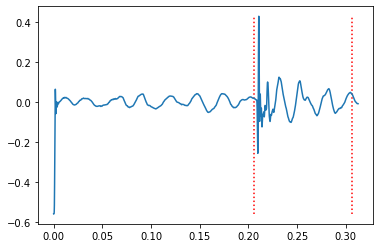

In [11]:
subsig, subbounds = signal_splice(sample, 0, 0.3125, sr, boundaries_nleo)
plot_boundaries_on_signal(subsig, subbounds, sr)

### Short-Time Energy Zero Crossing:

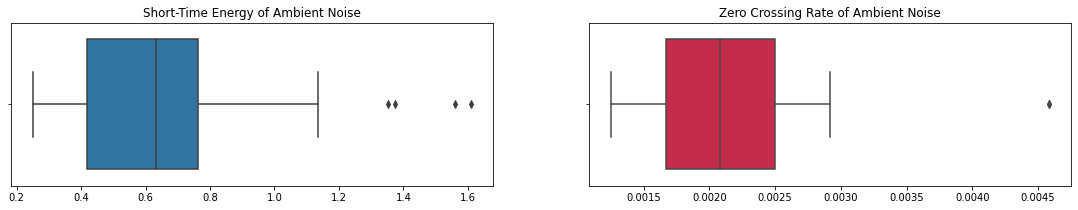

In [12]:
noise_sample, _ = signal_splice(sample, 3.1, 4.8, sr)
noise_energy = []
noise_zcr = []
for i in np.arange(0, 1.7, 0.05):
    frac = noise_sample[int(i*sr) : int((i+0.05)*sr)]
    noise_energy.append(sum(frac**2))
    noise_zcr.append(sum(abs(np.diff(frac>0)*1))/len(frac))

plt.figure(figsize=(19, 3))
plt.subplot(1,2,1)
sns.boxplot(x=noise_energy)
plt.title('Short-Time Energy of Ambient Noise')
plt.subplot(1,2,2)
sns.boxplot(x=noise_zcr, color='Crimson')
plt.title('Zero Crossing Rate of Ambient Noise')
plt.show()

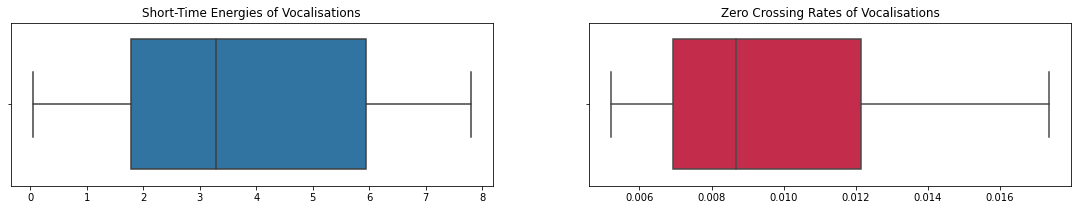

In [13]:
click_energy = []
click_zcr = []
# using every second boundary to get starting points of clicks.
for i in range(0,len(boundaries_nleo)-1,2):
    frac = sample[boundaries_nleo[i] : boundaries_nleo[i] + int(sr*0.012)]
    click_energy.append(sum(frac**2))
    click_zcr.append(sum(abs(np.diff(frac>0)*1))/len(frac))

plt.figure(figsize=(19, 3))
plt.subplot(1,2,1)
sns.boxplot(x=click_energy)
plt.title('Short-Time Energies of Vocalisations')
plt.subplot(1,2,2)
sns.boxplot(x=click_zcr, color='Crimson')
plt.title('Zero Crossing Rates of Vocalisations')
plt.show()

In [14]:
boundaries_ezcr = energy_zcr_vad(sample, 0.01, 0.005)
# print("Number of boundaries: ", len(boundaries_ezcr))
# print("Boundary locations: ", boundaries_ezcr)

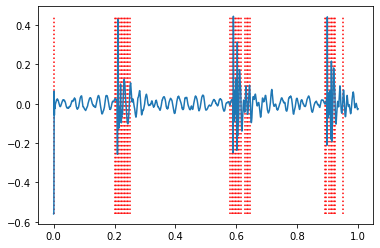

In [15]:
subsig_ezcr, subbounds_ezcr = signal_splice(sample, 0, 1, sr, boundaries_ezcr)
plot_boundaries_on_signal(subsig_ezcr, subbounds_ezcr, sr)